In [2]:
from music21 import *
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
import numpy as np
import collections
import copy

In [3]:
# Define local path to Music XML dataset 
score_path = './MusicXML'

<h1><center>Set-up and Plotting</center></h1>
The naming convention of the xml files in the SymbTr collection is as follows:

`makam--form--usul--lyrics--composer.xml`

### 1. Sort Makams:

We sort the Makam by their numbers of scores available and take the first **10** ones.

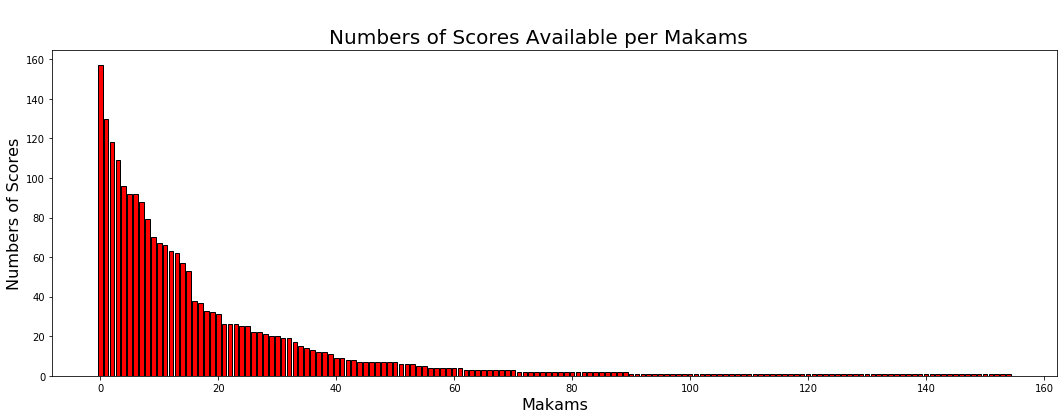

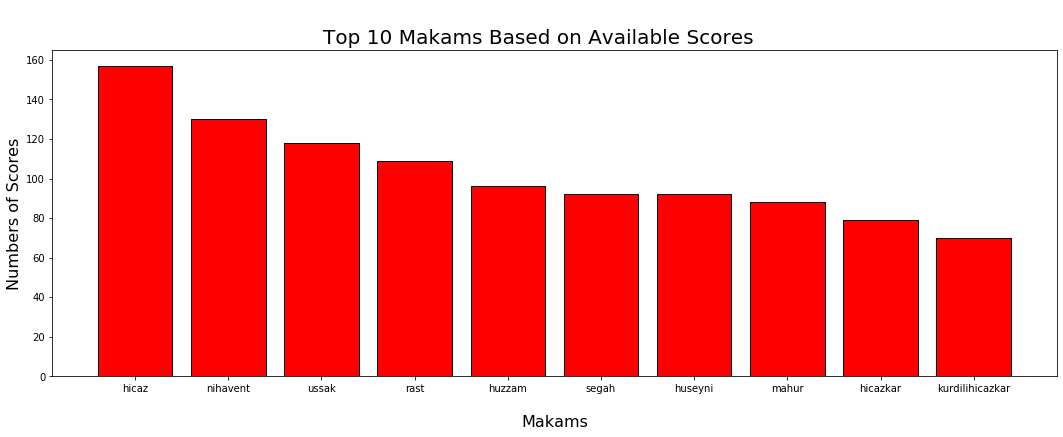

In [4]:
allScores = os.listdir(score_path)

scoresByMakams = {}

for score in allScores:
    if score.endswith('xml'):
        makam = score.split('--')[0]
        if makam in scoresByMakams:
            scoresByMakams[makam].append(score)
        else:
            scoresByMakams[makam] = [score]

# Sort the makams per numbers of scores available
num_scores_per_makam = []
top_makams = [] # Holds the makams in order of their available scores, descendingly.
for k in sorted(scoresByMakams, key=lambda k: len(scoresByMakams[k]), reverse=True):
    num_scores_per_makam.append(len(scoresByMakams[k]))
    top_makams.append(k)

# Plot the numbers of scores per makams
f1, ax1 = plt.subplots(figsize=(18,6))
plt.bar(range(len(num_scores_per_makam)), num_scores_per_makam, color='red', edgecolor='black')
f1.suptitle('\nNumbers of Scores Available per Makams', fontsize=20)
plt.xlabel('Makams', fontsize=16)
plt.ylabel('Numbers of Scores', fontsize=16)
plt.show()

# Only plot the numbers of scores per top makams (total = 10)
f2, ax2 = plt.subplots(figsize=(18,6))
plt.bar(range(10), num_scores_per_makam[:10], color='red', edgecolor='black', tick_label=top_makams[:10])
f2.suptitle('\nTop 10 Makams Based on Available Scores', fontsize=20)
plt.xlabel('\nMakams', fontsize=16)
plt.ylabel('Numbers of Scores', fontsize=16)
plt.show()

<h1><center>Pre-processing Scores</center></h1>

Now that we're clear on what scores we want to work with, we will have to:
* Remove the key signature from these score
* Rewrite all the scores and places then in a well formatted folder structure (each subfolder represent a makam)

**Notes:** If the folder mentioned below exist, this cell will simply be ignored

***
### 1. Remove Key Signatures from Scores

In [5]:
new_score_folder = score_path+'_WithoutKeySignature'
if not os.path.isdir(new_score_folder):
    os.mkdir(new_score_folder)
    for makam in top_makams[:10]:
        print('Processing '+makam+' scores...')
        makamDir = new_score_folder+'/'+makam
        os.mkdir(makamDir)
        for makamScore in scoresByMakams[makam]:

            # Remove the key signature from the xml file
            tree = ET.parse(os.path.join(score_path, makamScore))
            root = tree.getroot()

            for k in root.iter('key'):
                for ks in k.findall('key-step'):
                    k.remove(ks)
                for ka in k.findall('key-accidental'):
                    k.remove(ka)
                for ka in k.findall('key-alter'):
                    k.remove(ka)

            # Save the new xml files to be later loaded with music21
            newMakamScore = os.path.join(makamDir, makamScore[:-4] + '_withoutKeySignature.xml')
            tree.write(newMakamScore)
    print('Done!')
else:
    print('The folder with the new scores already exists at: '+new_score_folder)

The folder with the new scores already exists at: ./MusicXML_WithoutKeySignature


***
### 2. Retrieve Key Scale-Degrees for Each Makam

Before actually proceeding in seeking the Makam key degree in their respective score, we need to know what notes we are actually looking for. In this view, we will set up a dictionary containing the 10 makams as key and their respective key scale degrees as values:

In [6]:
# In the following order: Tonic, Dominant, Leading tone
degrees_for_makams = dict({'hicaz':['A','D','B'],
                           'nihavent':['G','D','F#'],
                           'ussak':['A','D','G'],
                           'rast':['G','D','F#'],
                           'huzzam':['A#','D','A'], # Contains odd flat on tonic/leading tone
                           'segah':['B`','D','A'],
                           'huseyni':['A','E','B'],
                           'mahur':['G','D','F'], # Contains odd sharp on leading tone
                           'hicazkar':['G','D','F#'],
                           'kurdilihicazkar':['G','C','F']})

In [31]:
from tqdm import tqdm
from time import sleep

adjacent = dict({'left':[],'right':[]})
adjacents_notes_tonic = {key:copy.deepcopy(adjacent) for key in top_makams[:10]}
adjacents_notes_domin = {key:copy.deepcopy(adjacent) for key in top_makams[:10]}
adjacents_notes_leadt = {key:copy.deepcopy(adjacent) for key in top_makams[:10]}

for root, dirs, files in os.walk(new_score_folder):
    
    current_makam_folder = root.split('/')[-1]
    
    if not current_makam_folder == new_score_folder.split('/')[-1]:
        print('Processing '+current_makam_folder+' makam scores...')
        sleep(1.0)
        current_makam_degrees = degrees_for_makams[current_makam_folder]
        for file in tqdm(files):
            if file.endswith('xml'):
                filepath = os.path.abspath(('{}/{}'.format(root,file)))
                s = converter.parse(filepath)
                nn = s.parts[0].flat.notes.stream()
                for idx, n in enumerate(nn):
                    # If == TONIC
                    if n.name == current_makam_degrees[0]:
                        if not idx == 0:
                            adjacents_notes_tonic[current_makam_folder]['left'].append(nn[idx-1].name)
                        if not idx >= len(nn)-1:
                            adjacents_notes_tonic[current_makam_folder]['right'].append(nn[idx+1].name)
                    # If == DOMINANT
                    elif n.name == current_makam_degrees[1]:
                        if not idx == 0:
                            adjacents_notes_domin[current_makam_folder]['left'].append(nn[idx-1].name)
                        if not idx >= len(nn)-1:
                            adjacents_notes_domin[current_makam_folder]['right'].append(nn[idx+1].name)
                    # If == LEADING TONE
                    elif n.name == current_makam_degrees[2]:
                        if not idx == 0:
                            adjacents_notes_leadt[current_makam_folder]['left'].append(nn[idx-1].name)
                        if not idx >= len(nn)-1:
                            adjacents_notes_leadt[current_makam_folder]['right'].append(nn[idx+1].name)
                        
print('\nFinished Processing Scores!\n')


Processing kurdilihicazkar makam scores...


100%|██████████| 70/70 [00:03<00:00, 18.22it/s]


Processing mahur makam scores...


100%|██████████| 88/88 [00:04<00:00, 20.18it/s]


Processing huseyni makam scores...


100%|██████████| 92/92 [00:04<00:00, 22.76it/s]


Processing huzzam makam scores...


100%|██████████| 96/96 [00:04<00:00, 21.64it/s]


Processing nihavent makam scores...


100%|██████████| 130/130 [00:06<00:00, 20.19it/s]


Processing segah makam scores...


100%|██████████| 92/92 [00:04<00:00, 20.77it/s]


Processing hicazkar makam scores...


100%|██████████| 79/79 [00:03<00:00, 20.20it/s]


Processing ussak makam scores...


100%|██████████| 118/118 [00:04<00:00, 25.43it/s]


Processing rast makam scores...


100%|██████████| 109/109 [00:04<00:00, 24.56it/s]


Processing hicaz makam scores...


100%|██████████| 157/157 [00:07<00:00, 22.12it/s]


Finished Processing Scores!



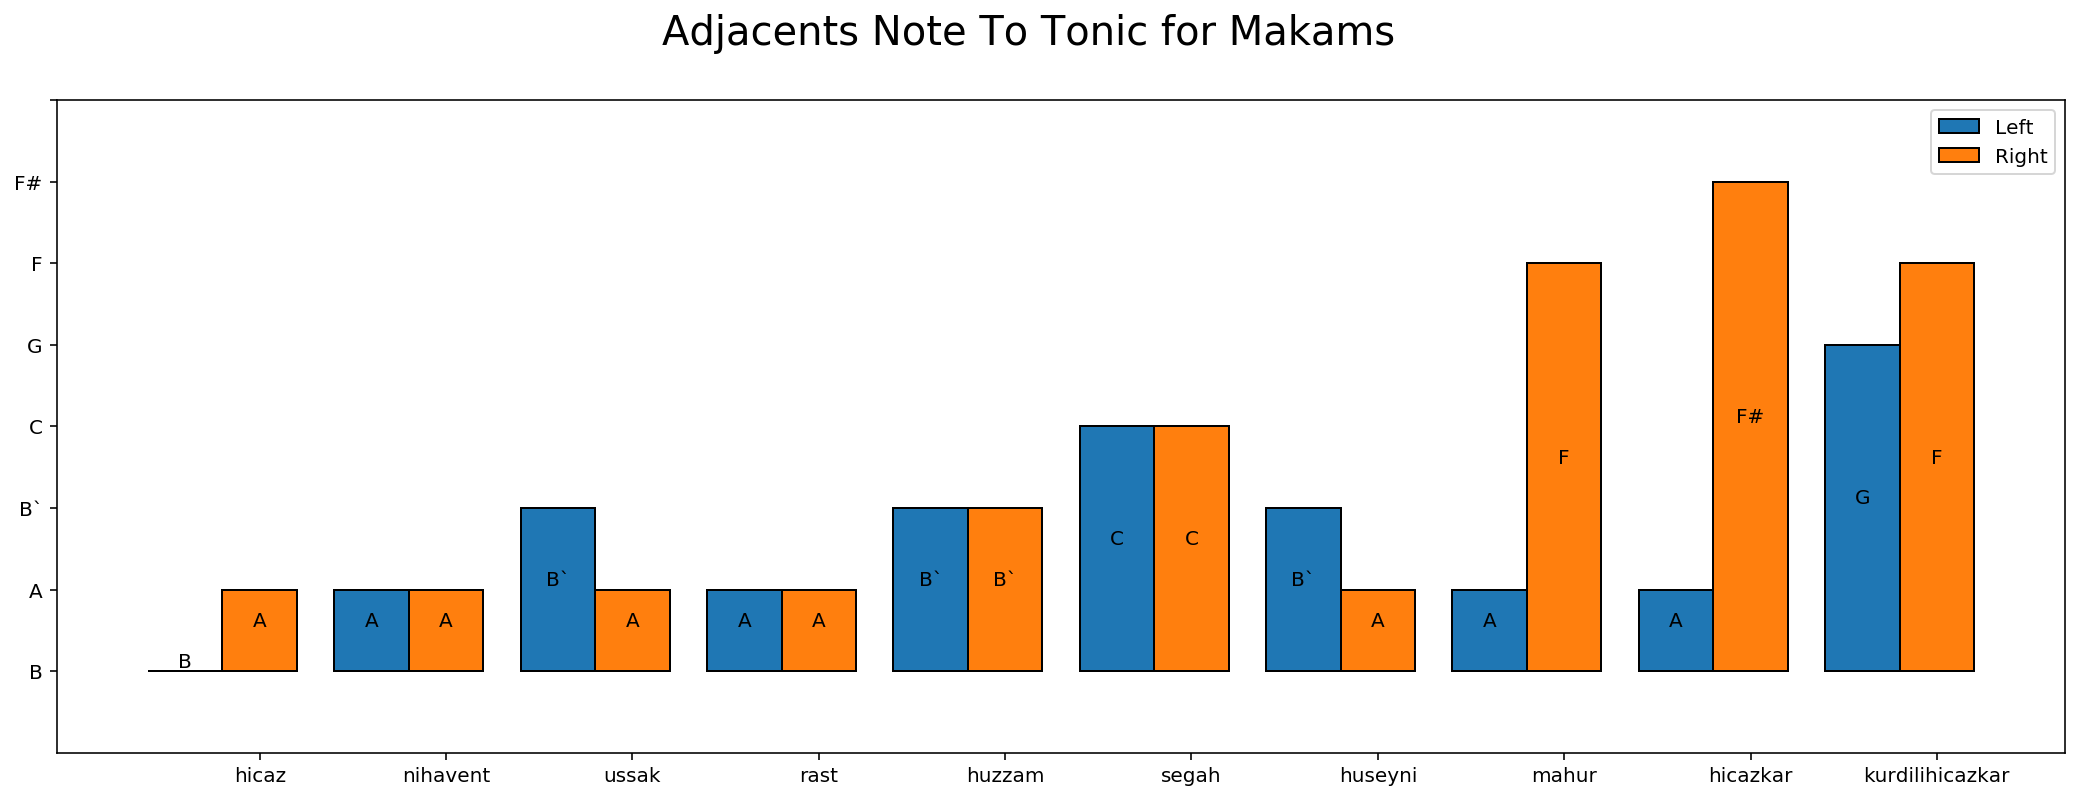

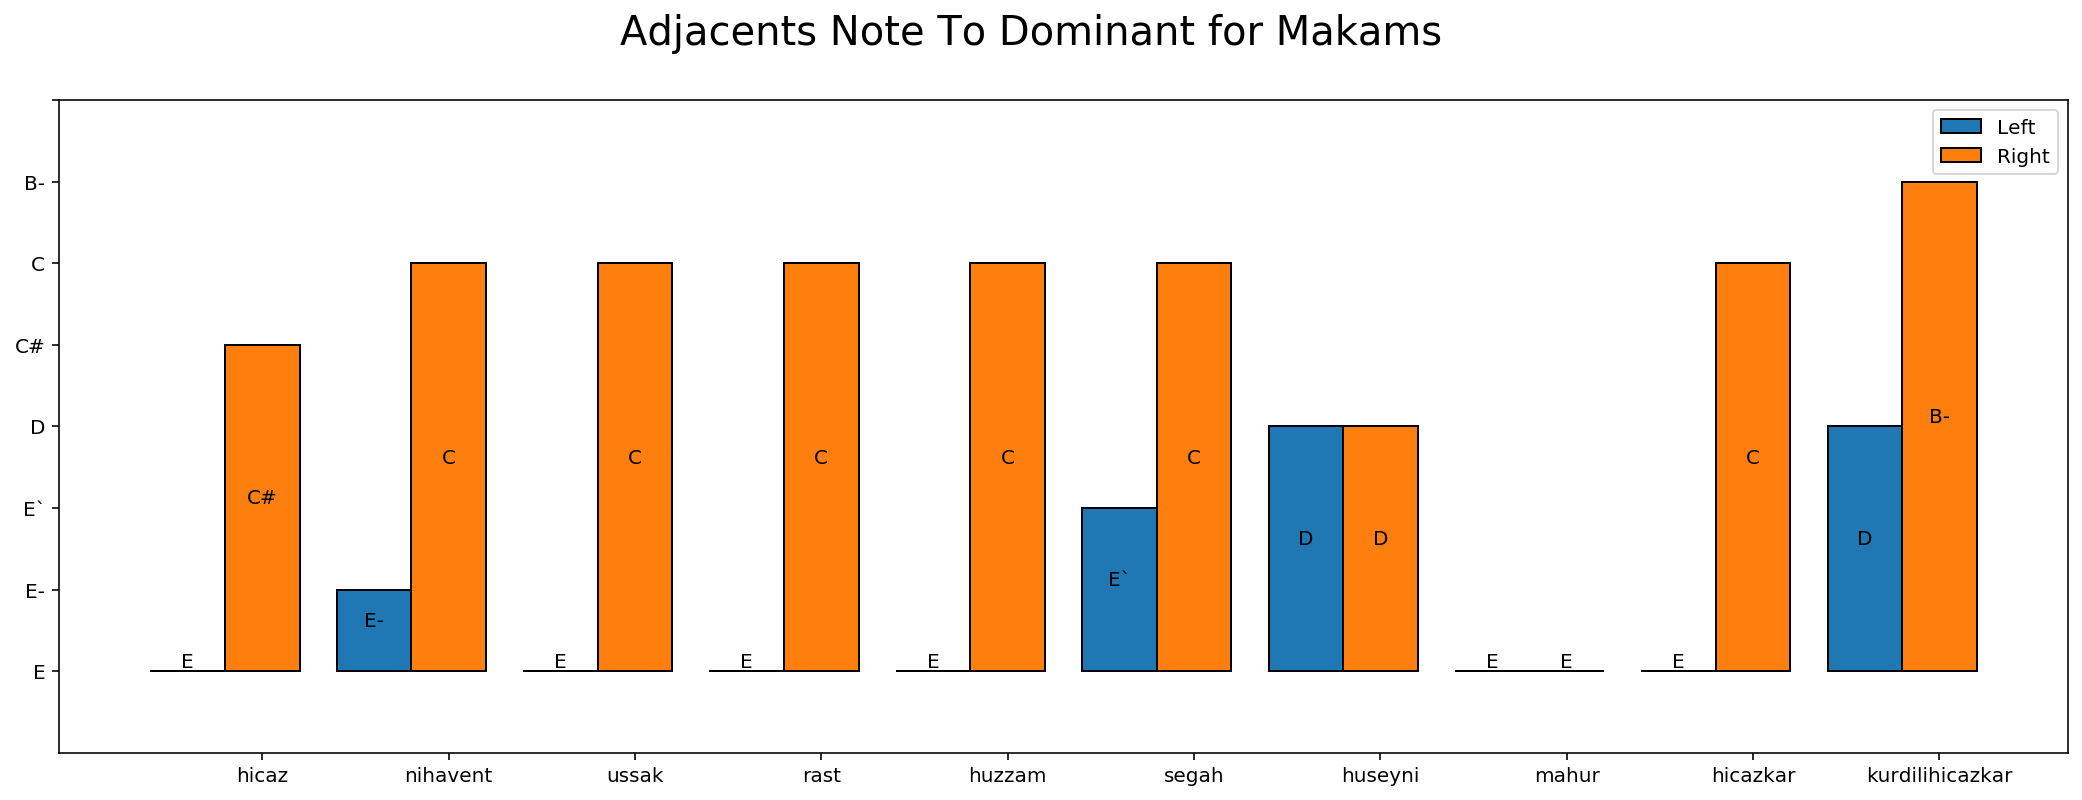

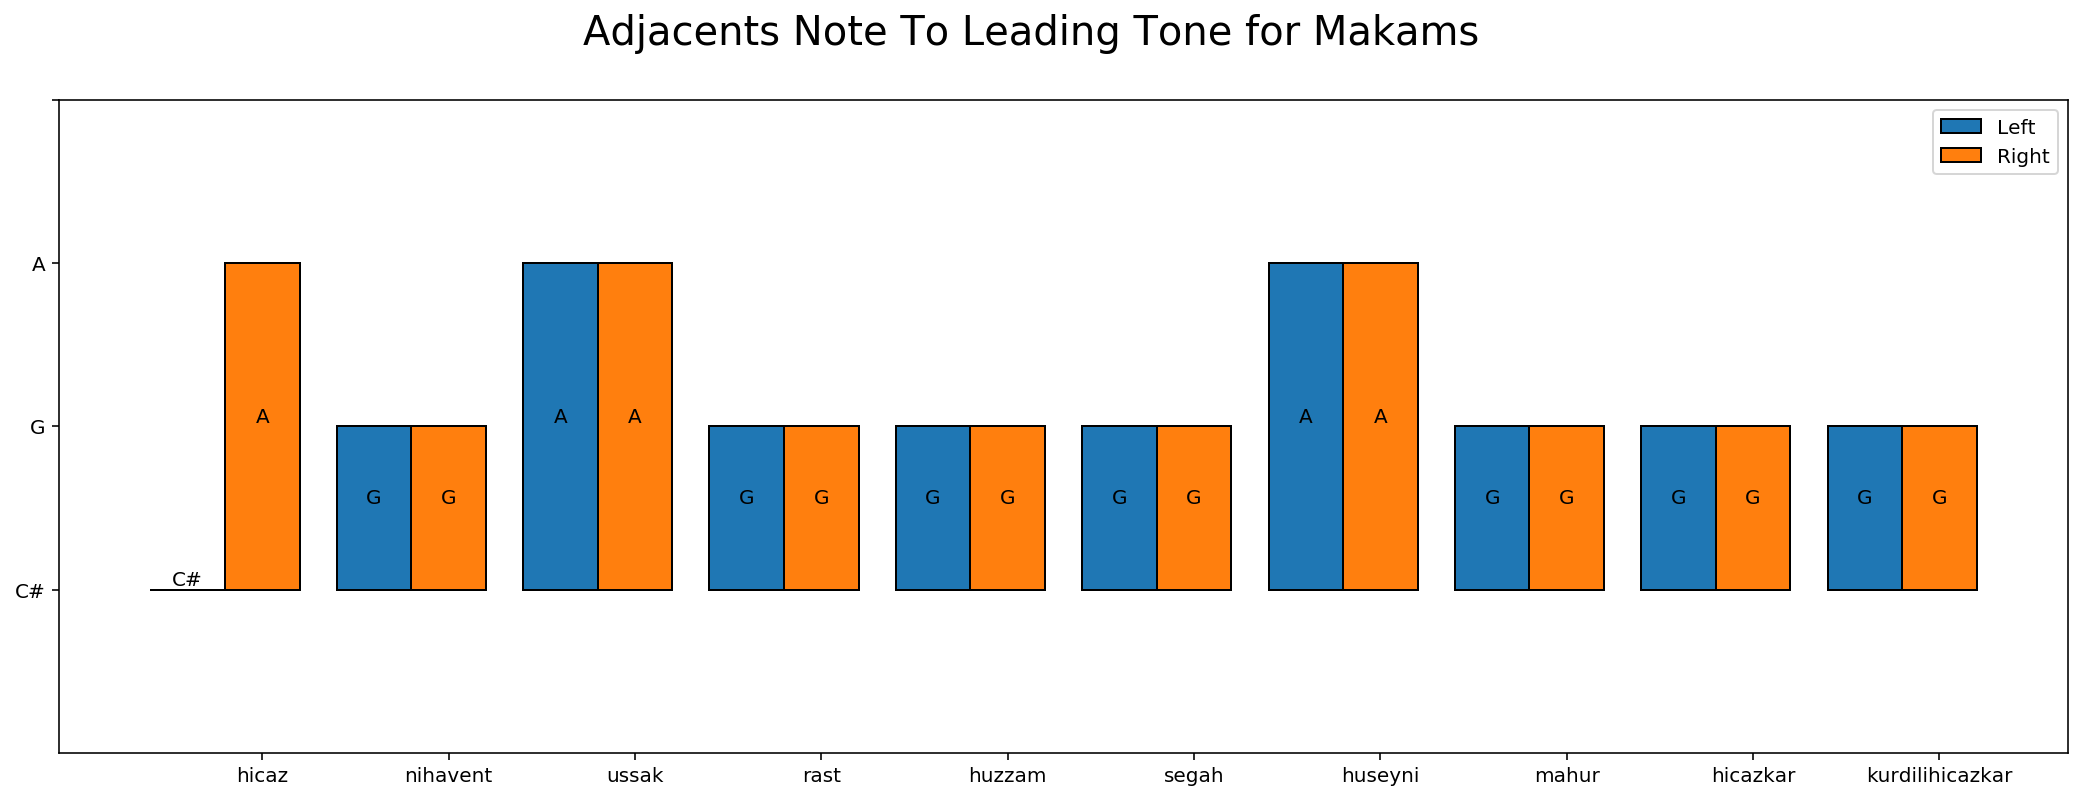

In [53]:
from collections import Counter

def autolabel(rects,labels):
    # attach some text labels
    for idx,rect in enumerate(rects):
        height = rect.get_height()
        label  = labels[idx]
        ax.text(rect.get_x() + rect.get_width()/2., 
                height/2,
                label,
                ha='center', va='bottom')

titles = ['Adjacent Notes To Tonic for Makams',
          'Adjacent Notes To Dominant for Makams',
          'Adjacent Notes To Leading Tone for Makams']

for idx, adjacent_array in enumerate([adjacents_notes_tonic,adjacents_notes_domin,adjacents_notes_leadt]):
    
    rights = []
    lefts = []
    makams = []
    title = titles[idx]
    
    for makam in adjacent_array.keys():    
        
        # Storing all stats for later plotting
        makams.append(makam)
        lefts.append(Counter(adjacent_array[makam]['left']).most_common(1)[0][0])
        rights.append(Counter(adjacent_array[makam]['right']).most_common(1)[0][0])
        
    ind = np.arange(10)
    f, ax = plt.subplots(figsize=(18,6))
    f.suptitle(title, fontsize=20)
    p1 = ax.bar(ind, lefts, 0.40,color='tab:blue', edgecolor='black', tick_label=makams)
    p2 = ax.bar(ind+0.4, rights, 0.40,color='tab:orange', edgecolor='black', tick_label=makams)
    ax.legend((p1[0], p2[0]), ('Left', 'Right'))
    ax.set_ylim((-1, ''))
    autolabel(p1,lefts)
    autolabel(p2,rights)
    plt.show()